<a href="https://colab.research.google.com/github/srijayjk/Computer-Vision/blob/main/CVAE_GRADCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is refered from 

## 0. Download required code and data

In [ ]:
!git clone https://github.com/Harvard-IACS/2019-computefest.git

Cloning into '2019-computefest'...
remote: Enumerating objects: 344, done.
remote: Total 344 (delta 0), reused 0 (delta 0), pack-reused 344
Receiving objects: 100% (344/344), 188.37 MiB | 25.66 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Checking out files: 100% (42/42), done.


In [ ]:
import os
os.chdir("/content/2019-computefest/Wednesday/auto_encoder")

In [ ]:
!ls

celeba	README.md	  Slides.pdf  VAE_Attendee.ipynb
models	requirements.txt  utils.py    VAE_Solutions.ipynb


In [ ]:
import keras
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Reshape, Dense, Lambda, Flatten
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import glob
import skimage
import skimage.transform
import skimage.io
import PIL
import numpy as np
import os
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import imageio
import utils

The major definition here will be our network architecture for the VAE. It follows an encoder-decoder architecture.

In [ ]:
def define_encoder_block(x, num_filters):  
    """
    Todo: Define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 2D max pooling layer (MaxPooling2D) (you can keep default arguments).
    """
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling2D()(x)
    return x

In [ ]:
def define_decoder_block(x, num_filters):
    """
    Todo: Define one 2D upsampling layer (UpSampling2D) (you can keep default arguments).
          Also, define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
    """
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x

In [ ]:
def define_net(variational, height, width, batch_size, latent_dim, conditioning_dim=0,
               start_filters=8):
    """Defines a (variational) encoder-decoder architecture.
    
    Args:
        variational: Whether a variational autoencoder should be defined.
        height: The height of the image input and output.
        width: The width of the image input and output.
        batch_size: The batchsize that is used during training. Must also be used for inference on the encoder side.
        latent_dim: The dimension of the latent space.
        conditioning_dim: The dimension of the space of variables to condition on. Can be zero for an unconditional VAE.
        start_filters: The number of filters to start from. Multiples of this value are used across the network. Can be used
            to change model capacity.
        
    Returns:
        Tuple of keras models for full VAE, encoder part and decoder part only.
    """
    
    # Prepare the inputs.
    inputs = Input((height, width, 3))
    if conditioning_dim > 0:
        # Define conditional VAE. Note that this is usually not the preferred way
        # of incorporating the conditioning information in the encoder.
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width)(condition)
        condition_up = Reshape([height, width, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs
    
    # Define the encoder.
    eblock1 = define_encoder_block(inputs_new, start_filters)
    eblock2 = define_encoder_block(eblock1, start_filters*2)
    eblock3 = define_encoder_block(eblock2, start_filters*4)
    eblock4 = define_encoder_block(eblock3, start_filters*8)
    _, *shape_spatial = eblock4.get_shape().as_list()
    eblock4_flat = Flatten()(eblock4)
    
    if not variational:
        z = Dense(latent_dim)(eblock4_flat)
    else:
        # Perform the sampling.
        def sampling(args):
            """Samples latent variable from a normal distribution using the given parameters."""
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_sigma) * epsilon
        
        z_mean = Dense(latent_dim)(eblock4_flat)
        z_log_sigma = Dense(latent_dim)(eblock4_flat)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])

    # Define the decoder.
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock4.shape.as_list()[1:])(embedding)
    
    dblock1 = define_decoder_block(embedding, start_filters*8)
    dblock2 = define_decoder_block(dblock1, start_filters*4)
    dblock3 = define_decoder_block(dblock2, start_filters*2)
    dblock4 = define_decoder_block(dblock3, start_filters)
    output = Conv2D(3, 1, activation = 'tanh')(dblock4)
    
    # Define the models.
    decoder = Model(inputs = inputs_embedding, outputs = output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model(inputs = [inputs, condition], outputs = z)
        encoder_with_sampling_ext = Model(inputs = [inputs, condition], outputs = z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model(inputs = [inputs, condition], outputs = vae_out)
    else:
        encoder_with_sampling = Model(inputs = inputs, outputs = z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model(inputs = inputs, outputs = vae_out)
    
    # Define the VAE loss.
    def vae_loss(x, x_decoded_mean):
        """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""
        mse_loss = K.mean(keras.losses.mse(x, x_decoded_mean), axis=(1,2)) * height * width
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return mse_loss + kl_loss
    
    if variational:
        vae.compile(loss=vae_loss, optimizer='adam')
    else:
        vae.compile(loss='mse', optimizer='adam')    
        
    print('done,', vae.count_params(), 'parameters.')
    return vae, encoder_with_sampling, decoder

Next, we define some functions to make encoding and decoding easier.

In [ ]:
def encode_image(img, conditioning, encoder, height, width, batch_size):
    '''Encodes an image that is given in RGB-channel order with value range of [0, 255].
    
    Args:
        img: The image input. If shapes differ from (height, width), it will be resized.
        conditoning: The set of values to condition on, if any. Can be None.
        encoder: The keras encoder model to use.
        height: The target image height.
        width: The target image width.
        batch_size: The batchsize that the encoder expects.
        
    Returns:
        The latent representation of the input image.
    '''
    if img.shape[0] != height or img.shape[1] != width:
        img = skimage.transform.resize(img, (height, width))
    img_single = np.expand_dims(img, axis=0)
    img_single = img_single.astype(np.float32)
    img_single = np.repeat(img_single, batch_size, axis=0)
    if conditioning is None:
        z = encoder.predict(img_single)
    else:
        z = encoder.predict([img_single, np.repeat(np.expand_dims(conditioning, axis=0), batch_size, axis=0)])
    return z

In [ ]:
def decode_embedding(z, conditioning, decoder):
    '''Decodes the given representation into an image.
    
    Args:
        z: The latent representation.
        conditioning: The set of values to condition on, if any. Can be None.
        decoder: The keras decoder model to use.
    '''
    if z.ndim < 2:
        z = np.expand_dims(z, axis=0) # Single-batch
    if conditioning is not None:
        z = np.concatenate((z, np.repeat(np.expand_dims(conditioning, axis=0), z.shape[0], axis=0)), axis=1)
    return decoder.predict(z)

In [ ]:
def load_weights(folder):
    vae.load_weights(folder + '/vae.w')
    encoder.load_weights(folder + '/encoder.w')
    decoder.load_weights(folder + '/decoder.w')
    
def save_weights(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    vae.save_weights(folder + '/vae.w')
    encoder.save_weights(folder + '/encoder.w')
    decoder.save_weights(folder + '/decoder.w')

For the face dataset CelebA, we will use a conditional VAE. We first define the hyperparameters to use for this experiment.

In [ ]:
VARIATIONAL = True
HEIGHT = 128
WIDTH = 128
BATCH_SIZE = 16
LATENT_DIM = 100
START_FILTERS = 32
CONDITIONING = True

Since this is a large dataset, we also define a custom data generator to avoid caching the whole set in memory.

In [ ]:
import tensorflow
class CustomDataGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, files, batch_size, target_height, target_width, conditioning_dim=0, conditioning_data=None):
        '''
        Intializes the custom generator.
        
        Args:
            files: The list of paths to images that should be fed to the network.
            batch_size: The batchsize to use.
            target_height: The target image height. If different, the images will be resized.
            target_width: The target image width. If different, the images will be resized.
            conditioning_dim: The dimension of the conditional variable space. Can be 0.
            conditioning_data: Optional dictionary that maps from the filename to the data to be
                conditioned on. Data must be numeric. Can be None. Otherwise, len must be equal to
                conditioning_dim.
        '''
        self.files = files
        self.batch_size = batch_size
        self.target_height = target_height
        self.target_width = target_width
        self.conditioning_dim = conditioning_dim
        self.conditioning_data = conditioning_data

    def on_epoch_end(self):
        '''Shuffle list of files after each epoch.'''
        np.random.shuffle(self.files)
        
    def __getitem__(self, index):
        cur_files = self.files[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(cur_files)
        return X, y
    
    def __data_generation(self, cur_files):
        X = np.empty(shape=(self.batch_size, self.target_height, self.target_width, 3))
        Y = np.empty(shape=(self.batch_size, self.target_height, self.target_width, 3))
        if self.conditioning_data != None:
            C = np.empty(shape=(self.batch_size, self.conditioning_dim))
        
        for i, file in enumerate(cur_files):
            img = skimage.io.imread(file)
            if img.shape[0] != self.target_height or img.shape[1] != self.target_width:
                img = skimage.transform.resize(img, (self.target_height, self.target_width)) # Resize.
            img = img.astype(np.float32) / 255.
            X[i] = img
            Y[i] = img
            if self.conditioning_data != None:
                C[i] = self.conditioning_data[os.path.basename(file)]
                
        if self.conditioning_data != None:
            return [X, C], Y
        else:
            return X, Y
    
    def __len__(self):
        return int(np.floor(len(self.files) / self.batch_size))

We will read the annotation data now.

In [ ]:
# Find image files.
files = glob.glob('celeba/img_align_celeba/*.jpg')
print(len(files), 'images found.')

df = utils.load_celeba('celeba/list_attr_celeba.txt')
columns = df.columns
df.head(3)

10 images found.


,Filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1


We convert the dataframe into a dictionary, mapping from filename to the individual image attributes. We then instantiate the generator.

In [ ]:
dd = {}
selected_conditionals = list(columns[1:])
for i, row in df.iterrows():
    dd[row['Filename']] = [int(row[c]) for c in selected_conditionals]

gen = CustomDataGenerator(files=files, 
                          batch_size=BATCH_SIZE, 
                          target_height=HEIGHT, 
                          target_width=WIDTH, 
                          conditioning_dim=len(selected_conditionals),
                          conditioning_data=dd if CONDITIONING else None)

Finally, we define the conditional VAE and start the training.

In [ ]:
vae, encoder, decoder = define_net(variational=VARIATIONAL,
                                   height=HEIGHT, 
                                   width=WIDTH, 
                                   batch_size=BATCH_SIZE, 
                                   latent_dim=LATENT_DIM,
                                   conditioning_dim=len(selected_conditionals) if CONDITIONING else 0, 
                                   start_filters=START_FILTERS)

done, 9192747 parameters.


In [ ]:
encoder.summary()
decoder.summary()
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16384)        671744      input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 128, 128, 1)  0           dense[0][0]                      
____________________________________________________________________________________________

In [ ]:
vae.fit_generator(gen, verbose=1, epochs=20)

Alternatively, we can load pre-trained weights:

In [ ]:
load_weights(folder='models/celeba_vae')

In [ ]:
# save_weights(folder='models/celeba_vae')

Let's look at some examples. First, we will select a random image from the CelebA dataset, and read the related annotation data.

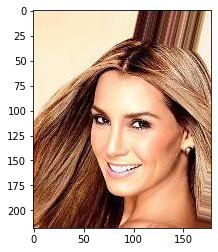

In [ ]:
rnd_file = np.random.choice(files)
file_id = os.path.basename(rnd_file)
init_meta = dd[file_id]
img = skimage.io.imread('/content/000001.jpg')
plt.imshow(img)
plt.show()

Now, we will encode the image into its latent representation.

In [ ]:
z = encode_image(img.astype(np.float32) / 255., np.array(init_meta), encoder, HEIGHT, WIDTH, BATCH_SIZE)
print('latent sample:\n', z[0])

latent sample:
 [-3.652446    1.8681396  -0.794359    2.7763822  -0.9257261   0.5987211
 -2.3982918  -3.7770188   0.15966633  0.8156403   1.8871232  -1.1033976
  1.16401     1.1344787   2.8415453   1.2980944 ]


latent sample:
 [-3.652446    1.8681396  -0.794359    2.7763822  -0.9257261   0.5987211
 -2.3982918  -3.7770188   0.15966633  0.8156403   1.8871232  -1.1033976
  1.16401     1.1344787   2.8415453   1.2980944 ]


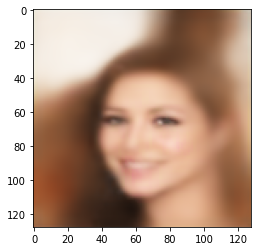

In [ ]:
print('latent sample:\n', z[0])
ret = decode_embedding(z, init_meta, decoder)
plt.imshow(ret[0])
plt.show()

Latent space

1) Z[0][1] = collar and Hair .... [-5, 0, 5, 10]
2) Z[0][2] = collar and Hair .... [-5, 0, 5, 10]


Decoding the latent representation should result in a face with somewhat similar characterics.

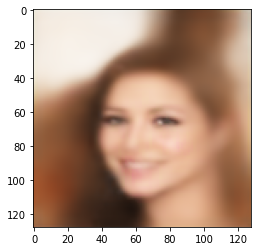

In [ ]:
ret = decode_embedding(z, init_meta, decoder)
plt.imshow(ret[0])
plt.show()

The next step is interesting: We can manipulate the embedding to change the facial structure. We can modify both our conditionals, as well as the latent variables. Here, we plot sliders to make the process interactive.

In [ ]:
# Note: Interactive widgets (i.e. this cell) will not work in Colab.

def render(**params):
    perturb_latent = np.zeros(shape=(LATENT_DIM))
    for i in range(LATENT_DIM):
        perturb_latent[i] = params['latent' + str(i)]

    c = []
    for k,v in params.items():
        if not k.startswith('latent'):
            c.append(v)
    ret = decode_embedding(z[0] + perturb_latent, conditioning=np.array(c), decoder=decoder)[0]
    ret = np.clip(ret, 0, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(ret)
    
lower, upper = -10, 10
params = {}
for i, c in enumerate(selected_conditionals):
    params[c] = widgets.FloatSlider(min=lower,max=upper,step=0.1,value=init_meta[i], layout=widgets.Layout(width='70%', height='20px'))
for c in ['latent' + str(i) for i in range(LATENT_DIM)]:
    params[c] = widgets.FloatSlider(min=lower,max=upper,step=0.1,value=0,layout=widgets.Layout(width='70%', height='20px'))
    
interactive_plot = interactive(render, **params)
output = interactive_plot.children[-1]
output.layout.height = '200px'
interactive_plot

In [ ]:
vae.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (16, 56)             2368608     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model_4 (Functional)            (None, 128, 128, 3)  2695203     model_6[0][0]              

In [ ]:
vae.get_layer('model_5').get_layer('conv2d_5')

In [ ]:
#Read Image and convert it to shape according to batch size
import sys
import cv2
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
img_path='/content/000001.jpg'
img = imread(img_path)
img = resize(img, (128, 128))
#imshow(img)
img_single = np.expand_dims(img, axis=0)
img_single = img_single.astype(np.float32)
img_single = np.repeat(img_single, 16, axis=0)

In [ ]:
img_single.shape #Verify image shape

In [ ]:
#Verify input is proper
import matplotlib
from google.colab.patches import cv2_imshow
res = img_single[0].squeeze()
from PIL import Image
res = res*255
res = res.astype(np.uint8)
res = Image.fromarray(res)
matplotlib.pyplot.imshow(res)

In [ ]:
#init_meta[17] = -1

In [ ]:
init_meta    #List shape 1*40 
init_meta=np.array(init_meta)   
a =np.repeat(np.expand_dims(init_meta, axis=0), 16, axis=0)

In [ ]:
a.shape

In [ ]:
output = vae.predict([img_single,a])    #Getting o/p of VAE

Latent Space Explore

In [ ]:
z = encode_image(img_single[0].astype(np.float32) / 255., np.array(init_meta), encoder, HEIGHT, WIDTH, BATCH_SIZE)
print('latent sample:\n', z[0])

In [ ]:
for i in range(-10, 20, 1):
  z[0][3] = i
  print('latent sample:\n', z[0])
  ret = decode_embedding(z, init_meta, decoder)
  plt.imshow(ret[0])
  plt.show()


In [ ]:
last_conv_layer_name = "conv2d_7"
encoder_out = "lambda"

In [ ]:
#Verifying the o/p
import matplotlib
from google.colab.patches import cv2_imshow
res = output[1].squeeze()
from PIL import Image
res = res*255
res = res.astype(np.uint8)
res = Image.fromarray(res)
matplotlib.pyplot.imshow(res)
#res.save("VAE_generated_image.jpeg")

In [ ]:
def make_gradcam_heatmap(img_array, init_meta, model, last_conv_layer_name, encoder_out, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer('model_2').get_layer(last_conv_layer_name).output, model.get_layer('model_2').get_layer(encoder_out).output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model([img_array, init_meta])   #VAE has 2 inputs
    
    grads = tape.gradient(preds, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
import tensorflow as tf
heatmap = make_gradcam_heatmap(img_single, a, vae, last_conv_layer_name, encoder_out)

In [ ]:
hm = np.uint8(255 * heatmap)
hm = np.expand_dims(hm, axis=2)
hm = tensorflow.keras.preprocessing.image.array_to_img(hm)
hm = hm.resize((img_single.shape[1], img_single.shape[2]))

matplotlib.pyplot.imshow(hm)


In [ ]:
def save_and_display_gradcam(img, heatmap,cam_path="superimposed_img.jpg", alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tensorflow.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tensorflow.keras.preprocessing.image.img_to_array(jet_heatmap)
    print(jet_heatmap.shape)
    print(img.shape)
    superimposed_img = cv2.addWeighted(jet_heatmap, 0.005, img, 0.995, 0)
    superimposed_img = tensorflow.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    matplotlib.pyplot.imshow(superimposed_img)

In [ ]:
import matplotlib.cm as cm
save_and_display_gradcam(img_single[0].squeeze(), heatmap)

In [ ]:
def save_individual_heatmaps_1(img_array, init_meta, model, last_conv_layer_name, encoder_out, pred_index=None):
  grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer('model_2').get_layer(last_conv_layer_name).output, model.get_layer('model_2').get_layer(encoder_out).output]
    )
  no_of_channels = ( model.get_layer('model_2').get_layer(encoder_out).output.get_shape())[1]
  for i in range(no_of_channels):
    with tf.GradientTape(persistent=True) as tape:
      last_conv_layer_output, preds = grad_model([img_array, init_meta])
      y = preds[0][i]
    grads = tape.gradient(y, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.matmul(last_conv_layer_output, pooled_grads[..., tf.newaxis])
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    save_and_display_gradcam(img_array[0].squeeze(), heatmap, cam_path="/content/"+str(i)+".jpg")
    

save_individual_heatmaps_1(img_single, a, vae, last_conv_layer_name, encoder_out)

In [ ]:
# Modify the following variables to change the face generated below.
# Set them to numbers between roughly -10 and 10.
# Large values might seem unrealistic, so try with small numbers first.
# If you set them to None, they will take the default values.

smiling = None # e.g. change this to -3 or 3 and see the results!
male = None
no_beard = None
attractive = None
bald = None
chubby = None
eyeglasses = None
young = None


# ------------------------------------
# Don't change the code below.
# It introduces the values you defined in the conditional vector
# that is used by the VAE.

meta = init_meta.copy()
meta[2] = attractive if attractive else init_meta[2]
meta[4] = bald if bald else init_meta[4]
meta[13] = chubby if chubby else init_meta[13]
meta[15] = eyeglasses if eyeglasses else init_meta[15]
meta[20] = male if male else init_meta[20]
meta[24] = no_beard if no_beard else init_meta[24]
meta[31] = smiling if smiling else init_meta[31]
meta[39] = young if young else init_meta[39]

ret = decode_embedding(z, meta, decoder)
plt.imshow(ret[0])
plt.show()

print('Attractive:', meta[2])
print('Bald:', meta[4])
print('Chubby:', meta[13])
print('Eyeglasses:', meta[15])
print('Male:', meta[20])
print('No_Beard:', meta[24])
print('Smiling:', meta[31])
print('Young:', meta[39])

Similar to our MNIST example, we can also visualize a grid of samples by just manipulating two of the dimensions.

In [ ]:
dim1 = 'Male' # you can change these to other attributes such as No_Beard or Young
dim2 = 'Smiling'
base_vec = np.array(list(z[0]) + meta)
rendering, _ = utils.display_manifold(
    decoder, 
    HEIGHT, 
    WIDTH, 
    base_vec, 
    bound_x=15, 
    bound_y=15, 
    axis_x=LATENT_DIM + selected_conditionals.index(dim1), 
    axis_y=LATENT_DIM + selected_conditionals.index(dim2), 
    n=10,
    desc_x = dim1,
    desc_y = dim2,
    file_out = 'rendering_celeba_' + dim1.lower() + '_' + dim2.lower() + '.png')

Additionally, we can create image sequences when manipulating a certain dimension. We save the result as an animated GIF.

In [ ]:
dim = 'Smiling' # you can change these to other attributes such as No_Beard or Young
utils.generate_gif(decoder, 
                   height=HEIGHT, 
                   width=WIDTH,
                   base_vec=np.array(list(base_vec)), 
                   axis=LATENT_DIM + selected_conditionals.index(dim),
                   total_frames=30,
                   degree=5,
                   file_out='animation_' + dim.lower() + '.gif')